## Train model for geometric shapes
**Function        : Train model in pytorch for geometric shapes **<br>
**Author          : Team DIANNA **<br>
**Contributor     : **<br>
**First Built     : 2021.05.26 **<br>
**Last Update     : 2021.05.26 **<br>
**Library         : os, numpy, matplotlib, torch, tensorflow, wandb **<br>
**Description     : In this notebook we train models in pytorch for geometric shapes. The trained models will be used to explore the XAI methods later.**<br>
**Return Values   : pytorch models and training status (.pt) / training report from weights & biases**<br>

In [1]:
%matplotlib inline
import os
import numpy as np
# DL framework
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
#import torchvision
# for plotting
import matplotlib.pyplot as plt
# report and monitoring with Weights & Biases
import wandb

In [2]:
#################################################################################
#########                     path to the dataset                        ########
#################################################################################
# please specify data path
datapath = '/mnt/d/NLeSC/DIANNA/data/geometric_shapes'
# please specify output path
output_path = '/mnt/d/NLeSC/DIANNA/codebase/dianna/train_models/geometric_shapes'

Dimensions of shapes data: (10000, 64, 64)
Dimensions of labels: (10000,)


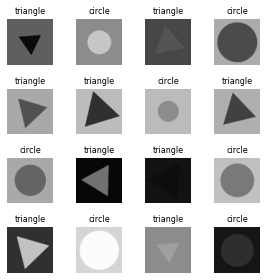

In [3]:
#################################################################################
#########          load and preprocess geometric shapes dataset          ########
#################################################################################
# load data
fd = np.load(os.path.join(datapath, 'shapes.npz'))
shapes_X = fd['X']
shapes_y = fd['y']
fd.close()
# define labels for each item in the dataset, circle=0, triangle=1
classes = ['circle', 'triangle']
# dimensions of data and label
print('Dimensions of shapes data:', shapes_X.shape)
print('Dimensions of labels:', shapes_y.shape)
# pre-check geometric shapes
overview_fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(4, 4))
axes = axes.flatten()

for i in range(16):
    a = axes[i]
    a.imshow(shapes_X[i], cmap='gray', vmin=0, vmax=1)
    a.set_title(classes[shapes_y[i]], fontsize=8)
    a.axis('off')
    
overview_fig.tight_layout()

In [4]:
print ('*******************  pre-process data  *********************')
# split dataset into training (85%) and testing set (15%)
training_size_ratio = 0.85

def preprocess(images, label, train_ratio):
    '''
    Function to preprocess the geometrics data and split dataset into training and testing sets.
    parameters
    images: input images
    label: label of input images
    train_ratio: percentage of training data w.r.t whole input dataset size
    '''
    dimension = images.ndim
    length = len(label)
    #check the input dimension
    if dimension == 3:
        pass
    else:
        raise IOError("This module only supports input images with 3 dimensions.")
    train_length = int(length * train_ratio)
    # training set
    train_X = images[:train_length,:,:]
    train_y = label[:train_length]
    # testing set
    test_X = images[train_length:,:,:]
    test_y = label[train_length:]
    # summary of training and testing sets
    print('Dimensions of training set:', train_X.shape)
    print('Dimensions of testing set:', test_X.shape)

    return train_X, train_y, test_X, test_y

# call the function to preprocess data
train_X, train_y, test_X, test_y = preprocess(shapes_X, shapes_y, training_size_ratio)

*******************  pre-process data  *********************
Dimensions of training set: (8500, 64, 64)
Dimensions of testing set: (1500, 64, 64)


In [5]:
#################################################################################
#########              set up the environment for training               ########
#################################################################################
print ('*******************  check the version of pytorch  *********************')
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('*******************  login weights & biases  *********************')
# call weights & biases service
# wandb.login()


*******************  check the version of pytorch  *********************
Pytorch version 1.8.1
Is CUDA available? False
*******************  login weights & biases  *********************


In [13]:
#################################################################################
#########                      build neural network                      ########
#################################################################################
class ShapesNet(nn.Module):
    def __init__(self, kernels=[16, 32], classes=2):
        '''
        Two layer CNN model with max pooling.
        '''
        super(ShapesNet, self).__init__()
        # 1st layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # 2nd layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(1, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(5 * 5 * kernels[-1], kernels[-1])
        self.fc2 = nn.Linear(kernels[-1], classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [11]:
#################################################################################
#########            configure hyper-parameters & prepare data           ########
#################################################################################
hyperparameters = dict(
    epoch = 20,
    classes = 2,
    kernels = [16, 32],
    batch_size = 100,
    learning_rate = 0.01,
    dataset = 'Geographic shapes',
    architecture = 'CNN'
)

# initialize weights & biases service
#wandb.init(project='train model for geometric shapes',config=hyperparameters)
wandb.init(config=hyperparameters)
config = wandb.config

# use pytorch data loader
train_X_torch = torch.from_numpy(train_X).type(torch.LongTensor)
train_y_torch = torch.from_numpy(train_y).type(torch.LongTensor)

test_X_torch = torch.from_numpy(test_X).type(torch.LongTensor)
test_y_torch = torch.from_numpy(test_y).type(torch.LongTensor)

# reshape the input following the definition in pytorch (batch, channel, Height, Width)
train_X_torch = train_X_torch.view(-1,1,64,64).float()
test_X_torch = test_X_torch.view(-1,1,64,64).float()

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch,train_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch,test_y_torch)

# data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)


wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: W&B syncing is set to `offline` in this directory.  Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


In [14]:
#################################################################################
#########               create model and choose optimizer                ########
#################################################################################
model = ShapesNet(config.kernels, config.classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)

Model details:
 ShapesNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)
Optimizer details:
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [ ]:
#################################################################################
#########                   start the training process                   ########
#################################################################################
# calculate the time for the code execution
start_time = tttt.time()
# switch model into train mode
model.train()
for epoch in range(config.epoch):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = Variable(X_batch).float()
        var_y_batch = Variable(y_batch)
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = criterion(output, var_y_batch)
        loss.backward()
        optimizer.step()

        # Total correct predictions
        predicted = torch.max(output.data, 1)[1] 
        correct += (predicted == var_y_batch).sum()
        #print(correct)
        if batch_idx % 10 == 0:
            print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                  epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.* batch_idx / len(train_loader),
                  loss.data[0], float(correct*100) / float(config.batch_size*(batch_idx+1))))

# save the general checkpoint
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.data[0]
            }, os.path.join(output_path,'shapesnet_training_checkpoint.pt'))

print ("--- %s minutes ---" % ((tttt.time() - start_time)/60))

In [ ]:
#################################################################################
#########                  start the evaluation process                  ########
#################################################################################
# switch model into evaluation mode
model.eval()
correct = 0
for test_imgs, test_labels in test_loader:
    #print(test_imgs.shape)
    test_imgs = Variable(test_imgs).float()
    output = model(test_imgs)
    predicted = torch.max(output,1)[1]
    correct += (predicted == test_labels).sum()
print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*config.batch_size)))
